## Big Data Group I : Intelligent Surveillance -- CNN Model Building Process

### Import all necessary packages

In [1]:
import cv2
from scipy.misc import imread
import pandas as pd
import numpy as np
import os

### Copy the image data set from http://vis-www.cs.umass.edu/lfw/lfw.tgz to lfw folder
### Align the faces in the LFW data set using openface package and dlib

In [2]:
#Generate aligned images for entrire data set and remove if any empty folders
!python3 ./openface/util/align-dlib.py ./lfw/ align outerEyesAndNose ./aligned-images-lfw/ --size 96

=== ./lfw/Jean_Chretien/Jean_Chretien_0044.jpg ===
=== ./lfw/Lleyton_Hewitt/Lleyton_Hewitt_0020.jpg ===
=== ./lfw/Jacques_Chirac/Jacques_Chirac_0031.jpg ===
=== ./lfw/Sercan/IMG_0912.jpg ===
=== ./lfw/Ozan/ozan20.jpg ===
=== ./lfw/John_Ashcroft/John_Ashcroft_0022.jpg ===
=== ./lfw/Rajesh/rajesh32.jpeg ===
=== ./lfw/Hans_Blix/Hans_Blix_0029.jpg ===
=== ./lfw/Jean_Chretien/Jean_Chretien_0038.jpg ===
=== ./lfw/Hans_Blix/Hans_Blix_0003.jpg ===
=== ./lfw/Gloria_Macapagal_Arroyo/Gloria_Macapagal_Arroyo_0012.jpg ===
=== ./lfw/Serena_Williams/Serena_Williams_0035.jpg ===
=== ./lfw/Biljana/IMG_6722.JPG ===
=== ./lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0004.jpg ===
=== ./lfw/Ozan/20170710_154109.jpg ===
Invalid SOS parameters for sequential JPEG
=== ./lfw/Hans_Blix/Hans_Blix_0035.jpg ===
=== ./lfw/Lleyton_Hewitt/Lleyton_Hewitt_0039.jpg ===
=== ./lfw/Serena_Williams/Serena_Williams_0023.jpg ===
=== ./lfw/Sean/20171019_232109.jpg ===
Invalid SOS parameters for sequential JPEG
=== .

In [3]:
#Define the align Data Set Path
dataSetPath = "./aligned-images-lfw/"

In [4]:
# List out all the person names in the aligned images
personNames = os.listdir(dataSetPath)

In [5]:
# Total Number of Persons or Classes to be classified
len(personNames)

20

In [6]:
numGrayImages = []

### Iterate through the aligned image data set and read the images and write to data frame
### Set a constraint to have atleast 10 images per person

In [7]:
for personName in personNames:
    personImages = os.listdir(dataSetPath+personName)
    if(len(personImages) >=10):
        for image in personImages:
            imageFileName  = os.path.join(dataSetPath,personName,image)
            #print(imageFileName)
            image = cv2.imread(imageFileName)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype('float32')
            #gray = gray[..., np.newaxis]
            #flatGray = gray.flatten()
            numGrayImages.append([personName,imageFileName, gray])

In [8]:
df = pd.DataFrame(numGrayImages,columns=['Name','ImagePath','Pixels'])

In [9]:
dict_labels = {}

### Keep the names and the corresponding classification number for further reference.

In [10]:
nameSet = set(df['Name'])
i=0
for name in nameSet:
    dict_labels[name] = i
    i=i+1

In [11]:
len(nameSet)

20

In [12]:
df['personCategory'] = [ dict_labels.get(name) for name in df['Name']]


In [13]:
len(df['personCategory'].unique())

20

In [14]:
df.head(3)

,Name,ImagePath,Pixels,personCategory
0,Rajesh,./aligned-images-lfw/Rajesh/rajesh38.png,"[[58.0, 58.0, 58.0, 56.0, 60.0, 58.0, 59.0, 68...",7
1,Rajesh,./aligned-images-lfw/Rajesh/rajesh35.png,"[[45.0, 44.0, 46.0, 48.0, 51.0, 55.0, 69.0, 97...",7
2,Rajesh,./aligned-images-lfw/Rajesh/rajesh12.png,"[[6.0, 7.0, 12.0, 12.0, 11.0, 11.0, 31.0, 54.0...",7


In [15]:
df['Pixels'][0].shape

(96, 96)

In [16]:
len(df['Name'].unique())

20

In [17]:
import matplotlib.pyplot as plt
plt.imshow(df['Pixels'][0], cmap=plt.cm.gray)
plt.show()

<Figure size 640x480 with 1 Axes>

### Save the data to the csv fine along with the names the same we will use in 
### recognizing the image file to get the classification number of each individual.

In [18]:
df.to_csv("./LFWGrayImagesWithPixels_Modified_gt10.csv")

### Create the Training Data set, validation Set for cross validation and Test Data set to test the model accuracy
### Save the data to the files for further reference.

In [19]:
from sklearn.model_selection import train_test_split
training_set1 ,test_set = train_test_split(df,test_size=0.20)

In [20]:

test_set.to_csv("./LFWTestSet_Modified.csv")

In [21]:
training_set ,validation_set = train_test_split(training_set1,test_size=0.10)

In [22]:
training_set.to_csv("./LFWTrainSet_Modified.csv")
validation_set.to_csv("./LFWValidationSet_Modified.csv")

In [23]:
df.shape

(839, 4)

### Import all the packages required for the Nueral Network Model Building

In [24]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
#from keras import backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/home/rajesh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [25]:
training_set.shape,validation_set.shape, test_set.shape

((603, 4), (68, 4), (168, 4))

### Define the learning rate, epoch value and batch size for the Neural Network Model.

In [26]:
learning_rate = 0.001
epochs_value = 12
batch_size_value = 32

seed = 123; np.random.seed(seed); tf.set_random_seed(seed)

In [27]:
# Few constants, Image related
IMAGE_SIZE = 96; 
VALIDATION_PERCENT = 0.1  
IMAGE_LOCATION_NORM = IMAGE_SIZE / 2
NUM_LABELS = len(dict_labels)

### Define th training, validation and test data set dimensions to fit our network topology

In [28]:
train_data=training_set['Pixels']/255.0
train_labels = training_set['personCategory']
eval_data = validation_set['Pixels']/255.0
eval_labels = validation_set['personCategory']
test_images = test_set['Pixels']/255.0

In [29]:
train_data.shape, train_labels.shape, eval_data.shape, eval_labels.shape, test_images.shape

((603,), (603,), (68,), (68,), (168,))

In [30]:
train_data = train_data.values

In [31]:
train_data = np.array([ data.reshape(IMAGE_SIZE, IMAGE_SIZE, 1) for data in train_data])

In [32]:
train_data.shape

(603, 96, 96, 1)

In [33]:
eval_data = np.array([ data.reshape(IMAGE_SIZE, IMAGE_SIZE, 1) for data in eval_data])

In [34]:
test_images = np.array([ data.reshape(IMAGE_SIZE, IMAGE_SIZE, 1) for data in test_images])

In [35]:
eval_data.shape

(68, 96, 96, 1)

In [36]:
train_labels = train_labels.values

In [37]:
eval_labels = eval_labels.values

In [38]:
eval_labels = keras.utils.to_categorical(eval_labels, NUM_LABELS)
train_labels = keras.utils.to_categorical(train_labels, NUM_LABELS)

In [39]:
train_data.shape, train_labels.shape, eval_data.shape, eval_labels.shape, test_images.shape

((603, 96, 96, 1), (603, 20), (68, 96, 96, 1), (68, 20), (168, 96, 96, 1))

In [40]:
test_labels = test_set['personCategory']

In [41]:
test_labels = keras.utils.to_categorical(test_labels.values, NUM_LABELS)

In [42]:
test_labels.shape

(168, 20)

### Create the name Dictionary with key as label number and value as Person Name

In [43]:
nameDict={}

In [44]:
nameSet = set(df['Name'])
i=0
for name in nameSet:
    nameDict[i] = name
    i=i+1

In [46]:
nameDict[0]

'Serena_Williams'

### Build the Neural Network model with 13 layers, compile and train the model

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(96, 96,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(256, activation='relu'))
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(NUM_LABELS, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
__________

In [48]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),  metrics=['accuracy'])

In [49]:
training_model = model.fit(train_data, train_labels, batch_size=batch_size_value, epochs=epochs_value, verbose=1, validation_data=(eval_data, eval_labels))

Train on 603 samples, validate on 68 samples
Epoch 1/12
603/603 [==============================] - 14s 23ms/step - loss: 2.1118 - acc: 0.3964 - val_loss: 1.6963 - val_acc: 0.4706
Epoch 2/12
603/603 [==============================] - 12s 21ms/step - loss: 0.5019 - acc: 0.9187 - val_loss: 1.8081 - val_acc: 0.5294
Epoch 3/12
603/603 [==============================] - 12s 20ms/step - loss: 0.1649 - acc: 0.9917 - val_loss: 1.7223 - val_acc: 0.4265
Epoch 4/12
603/603 [==============================] - 12s 21ms/step - loss: 0.0658 - acc: 0.9967 - val_loss: 1.9148 - val_acc: 0.3971
Epoch 5/12
603/603 [==============================] - 12s 21ms/step - loss: 0.0376 - acc: 1.0000 - val_loss: 0.8936 - val_acc: 0.7794
Epoch 6/12
603/603 [==============================] - 12s 21ms/step - loss: 0.0266 - acc: 1.0000 - val_loss: 0.6729 - val_acc: 0.8088
Epoch 7/12
603/603 [==============================] - 12s 21ms/step - loss: 0.0166 - acc: 1.0000 - val_loss: 0.6723 - val_acc: 0.8382
Epoch 8/12
603/60

### Evaluate the model with the test data set

In [50]:
result = model.evaluate(test_images, test_labels, verbose=1)
result

168/168 [==============================] - 1s 8ms/step


[0.5581428295090085, 0.8452380952380952]

In [51]:
len(model.layers)

13

In [52]:
score = model.evaluate(eval_data, eval_labels, verbose=1)
print('Eval loss:', score[0])
print('Eval accuracy:', score[1]) 
training_model.history['acc'], training_model.history['val_acc']

68/68 [==============================] - 1s 8ms/step
Eval loss: 0.5212104522130069
Eval accuracy: 0.8970588235294118


([0.39635157466527837,
  0.9187396344656177,
  0.9917081260364843,
  0.9966832504145937,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.47058823529411764,
  0.5294117647058824,
  0.4264705882352941,
  0.39705882352941174,
  0.7794117647058824,
  0.8088235294117647,
  0.8382352941176471,
  0.8676470588235294,
  0.8382352941176471,
  0.8382352941176471,
  0.8970588235294118,
  0.8970588235294118])

### Save the model to be used in the Image tagging application

In [53]:
model.save('tagFaceFinalModel.keras', overwrite=True)

In [54]:
for name, value in zip(model.metrics_names, result):
    print (name, value)

loss 0.5581428295090085
acc 0.8452380952380952


### Plot the training and evaluation accuracy

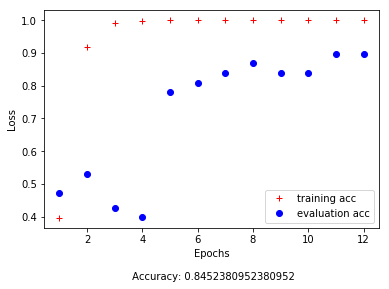

In [55]:
plt.plot(range(1,epochs_value+1), training_model.history['acc'], 'r+', label='training acc')
plt.plot(range(1,epochs_value+1), training_model.history['val_acc'], 'bo', label='evaluation acc')
plt.xlabel('Epochs\n\n Accuracy: '+str(value))
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot the test images along with prediction labels and actual labels

In [56]:
def plot_images(images, cls_true, cls_pred=None):
    n = int(np.sqrt(len(images))) 
    fig, axes = plt.subplots(n, n +1)
    fig.subplots_adjust(hspace=1, wspace=1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if(i<len(images)):
            ax.imshow(images[i].reshape(96,96), cmap=plt.cm.gray)

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "Actual: {0}".format(cls_true[i])
            else:
                xlabel = "Actual: {0},\n Prediction: {1}".format(cls_true[i], cls_pred[i])

            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()

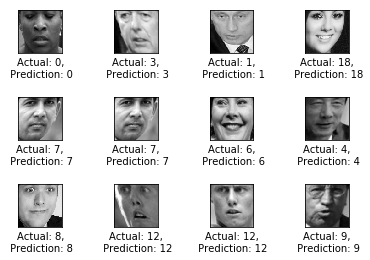

In [57]:
R_img = range (0,15)
plot_images(test_images[R_img], np.argmax(test_labels[R_img],axis=1), np.argmax(model.predict(test_images[R_img]), axis=1))

In [58]:
np.max(model.predict(test_images[0:20]),axis=1)

array([0.99416673, 0.9836443 , 0.98786455, 0.81647635, 0.8517395 ,
       0.8896222 , 0.9100038 , 0.84225905, 0.99534273, 0.54774016,
       0.94541025, 0.41191348, 0.98341113, 0.7719185 , 0.99111474,
       0.92236227, 0.85203755, 0.9631406 , 0.3294843 , 0.40403447],
      dtype=float32)

In [59]:
np.argmax(model.predict(test_images[0:20]), axis=1)

array([ 0,  3,  1, 18,  7,  7,  6,  4,  8, 12, 12,  9,  8,  3,  5,  1, 17,
       16,  5,  6])

In [60]:
np.argmax(test_labels[0:20],axis=1)

array([ 0,  3,  1, 18,  7,  7,  6,  4,  8, 12, 12,  9,  8,  3,  5,  1,  7,
       16, 15,  6])